In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import sys; sys.path.insert(1, 'scripts')
from wildlifeml.utils.io import (
    load_csv, 
    load_json, 
    load_pickle)
import results_functions as rf

2022-12-04 16:01:42.238078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-04 16:01:42.444303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-04 16:01:42.749742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-12-04 16:01:42.843029: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-04 16:01:43.524624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-04 16:01:43.673491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [3]:
repo_dir = '/home/wimmerl/projects/wildlife-experiments'
image_data_dir = '/common/bothmannl/wildlife_images/usecase2/original_images/'
print_metrics = ['acc', 'prec', 'rec', 'f1']

In [4]:
cfg = load_json(os.path.join(repo_dir, 'configs/cfg.json'))

label_map = load_json(
    os.path.join(cfg['data_dir'], 'label_map.json')
)

labels = list(label_map.keys())

empty_map = {}
for k, v in label_map.items():
    if k == 'empty':
        empty_map[k] = 'empty'
    else:
        empty_map[k] = 'non_empty'

label_dict = {k: v for k, v in load_csv(os.path.join(cfg['data_dir'], cfg['label_file']))}

detector_dict = load_json(
    os.path.join(cfg['data_dir'], cfg['detector_file'])
)

df_meta = pd.read_csv(os.path.join(cfg['data_dir'], 'metadata.csv'))
df_meta = df_meta.rename(columns={'orig_name':'img_name'})
df_ins = df_meta[df_meta['station_set']=='s1']
df_oos = df_meta[df_meta['station_set']=='s2']

# Global

In [4]:
# Relative frequencies of classes in all, ins & oos datasets
df = pd.DataFrame(index=labels)
df['all'] = rf.get_frequencies(df_meta, label_map, normalize=True)
df['ins'] = rf.get_frequencies(df_ins, label_map, normalize=True)
df['oos'] = rf.get_frequencies(df_oos, label_map, normalize=True)
df

,all,ins,oos
empty,0.621436,0.641292,0.601061
european_hare,0.015379,0.019903,0.010738
others,0.041400,0.038616,0.044256
red_deer,0.003346,0.001067,0.005685
red_fox,0.016917,0.029054,0.004464
red_squirrel,0.006443,0.012188,0.000547
roe_deer,0.271926,0.249261,0.295183
wild_boar,0.023152,0.008618,0.038066


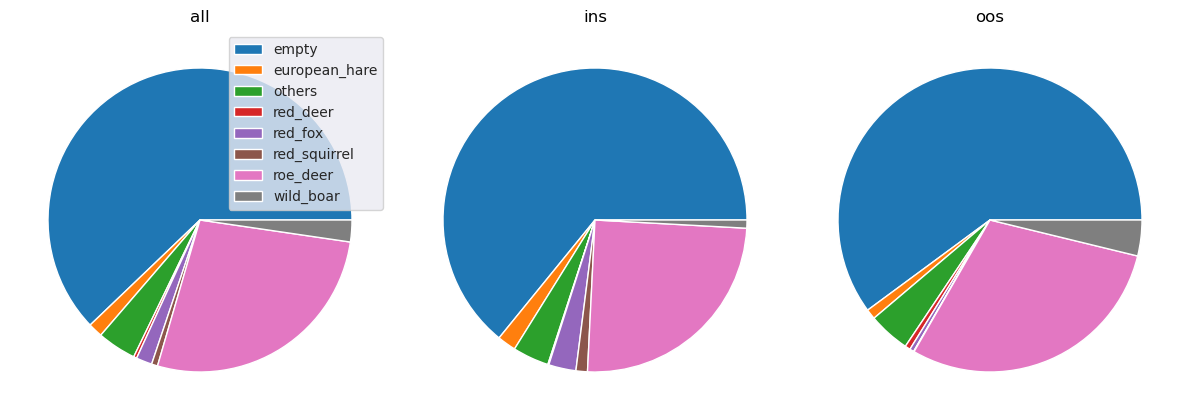

In [5]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(12,5),  tight_layout=True)

for i, (title, df) in enumerate(zip(['all', 'ins', 'oos'], [df_meta, df_ins, df_oos])):
    rf.plot_frequencies(
        df=df, 
        label_map=label_map, 
        ax=ax[i],
    )
    ax[i].set_title(title)
ax[0].legend(labels, loc="best", fontsize=10)
plt.show()
plt.close()

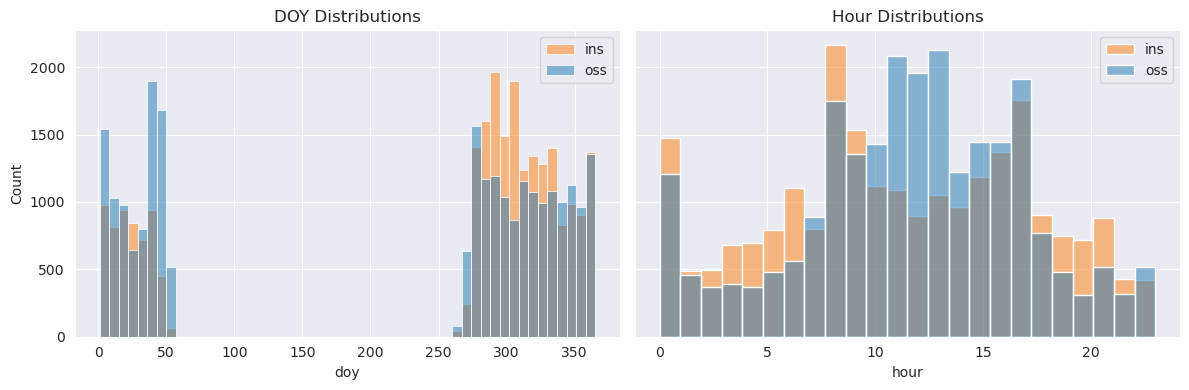

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True, tight_layout=True)
sns.histplot(data=df_meta, x='doy', hue='station_set', hue_order=['s1', 's2'], ax=ax[0], bins=52)
ax[0].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[0].set_title('DOY Distributions')

sns.histplot(data=df_meta, x='hour', hue='station_set', hue_order=['s1', 's2'], ax=ax[1], bins=24)
ax[1].legend(['ins', 'oss'], loc="best", fontsize=10)
ax[1].set_title('Hour Distributions')
plt.show()

# IN-SAMPLE

In [7]:
eval_details_path = 'results/202211251613_details_insample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
pref_dict = rf.evaluate_performance(df_pred['true_class'], df_pred['pred_class'], labels, average='macro',)

macro_perf_ins = {metric: pref_dict[metric] for metric in print_metrics}
print(macro_perf_ins)

{'acc': 0.8843967150979154, 'prec': 0.869295009617693, 'rec': 0.7694201742279487, 'f1': 0.812167083286727}


               precision    recall  f1-score   support

        empty       0.87      0.90      0.88       347
european_hare       0.84      0.78      0.81        65
       others       0.61      0.59      0.60       112
     red_deer       1.00      0.67      0.80         3
      red_fox       0.90      0.77      0.83        95
 red_squirrel       0.91      0.81      0.86        48
     roe_deer       0.92      0.95      0.93       884
    wild_boar       0.91      0.69      0.78        29

     accuracy                           0.88      1583
    macro avg       0.87      0.77      0.81      1583
 weighted avg       0.88      0.88      0.88      1583



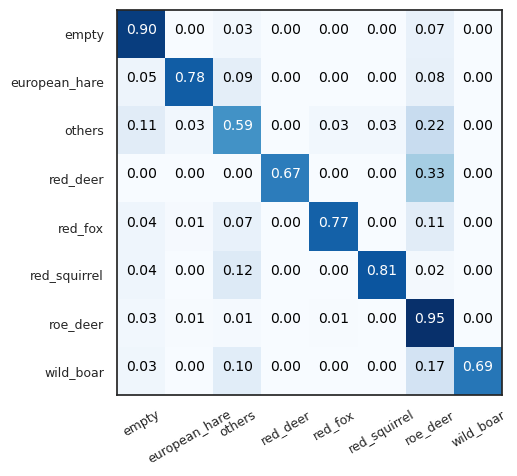

In [8]:
#_paper_

# Table: confusion matrix and recall/precision
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

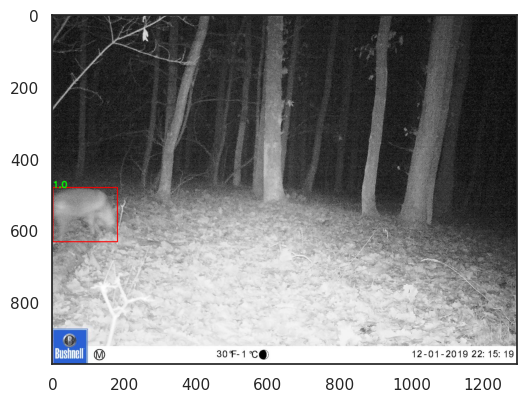

img_name: 18208_12010538.JPG
true_class: roe_deer
pred_class: others
pred_score: 0.821
n_preds: 1
pred_classes: ['others']
pred_confs: [0.821]
md_confs: [1.0]
score_dict: {'others': 0.821, 'roe_deer': 0.141, 'red_fox': 0.033, 'european_hare': 0.005, 'empty': 0.0, 'red_deer': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [9]:
#_paper_

# Perhaps show some missclassified images
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='roe_deer', 
    label_map=label_map,
    n_displays=1, 
    is_truth=True,
    sorting='random',
)


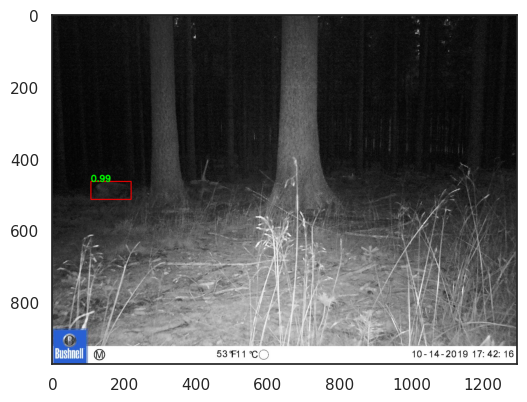

img_name: 6461_10140047.JPG
true_class: roe_deer
pred_class: empty
pred_score: 0.908
n_preds: 1
pred_classes: ['empty']
pred_confs: [0.913]
md_confs: [0.99]
score_dict: {'empty': 0.908, 'roe_deer': 0.086, 'european_hare': 0.0, 'others': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'wild_boar': 0.0}


In [10]:
# Perhaps show some missclassified images
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='roe_deer', 
    label_map=label_map,
    n_displays=1, 
    is_truth=True,
    sorting='decending',
)

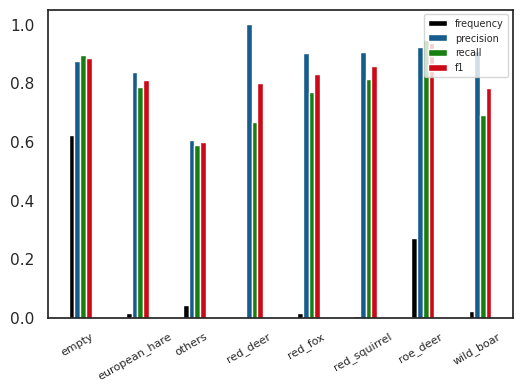

In [11]:
rf.plot_class_performance(
    df_pred=df_pred, 
    df_meta=df_meta, 
    label_map=label_map, 
    ax=None)

# EMPTY VS NON-EMPTY

In [12]:
#eval_results_path = 'results/202211181014_results_insample_empty.json'
#eval_details_path = 'results/202211181014_details_insample_empty.pkl'
eval_results_path = 'results/202211251652_results_insample_empty.json'
eval_details_path = 'results/202211251652_details_insample_empty.pkl'

eval_results_dict = load_json(eval_results_path)
eval_details_dict = load_pickle(eval_details_path)
df = pd.DataFrame(eval_results_dict)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    
    # performance on binary classification
    pref_b = rf.evaluate_performance(
        y_true=df_pred['true_class'].map(empty_map), 
        y_pred=df_pred['pred_class'].map(empty_map), 
        labels=['non_empty', 'empty'], 
        average=None,
    )
    
    # performance on multiclass classification
    pref_m = rf.evaluate_performance(
        y_true=df_pred['true_class'], 
        y_pred=df_pred['pred_class'], 
        labels=labels, 
        average='macro',
    )
    
    df.loc[index_tresh, 'acc_b'] = pref_b['acc']
    df.loc[index_tresh, 'prec_b'] = pref_b['prec'][0]
    df.loc[index_tresh, 'rec_b'] = pref_b['rec'][0]
    df.loc[index_tresh, 'f1_b'] = pref_b['f1'][0]
    
    df.loc[index_tresh, 'acc_m'] = pref_m['acc']
    df.loc[index_tresh, 'prec_m'] = pref_m['prec']
    df.loc[index_tresh, 'rec_m'] = pref_m['rec']
    df.loc[index_tresh, 'f1_m'] = pref_m['f1']

#_paper_
#Table: rates for 3 different thresholds: ours, 0.5, 0.9

df

,names,thresholds,tnr_md,tpr_md,fnr_md,fpr_md,tnr_ppl,tpr_ppl,fnr_ppl,fpr_ppl,acc_b,prec_b,rec_b,f1_b,acc_m,prec_m,rec_m,f1_m
0,ours,0.1,0.0000,1.0000,0.0000,1.0000,0.8069,0.9830,0.0170,0.1931,0.944409,0.947738,0.983010,0.965052,0.876816,0.873429,0.755143,0.805069
1,progressive,0.5,0.5573,0.8795,0.1205,0.4427,0.9078,0.9668,0.0332,0.0922,0.953885,0.973920,0.966828,0.970361,0.899558,0.880515,0.807944,0.836943
2,norouzzadeh,0.9,0.7514,0.8452,0.1548,0.2486,0.9280,0.9401,0.0599,0.0720,0.937461,0.978939,0.940129,0.959142,0.869867,0.699279,0.676959,0.686165


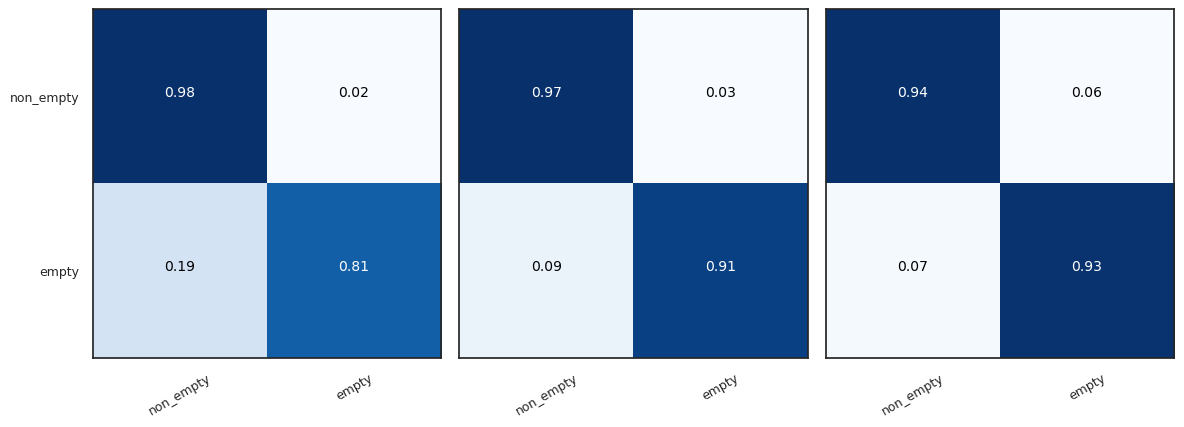

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    df_pred['true_class'] = df_pred['true_class'].map(empty_map)
    df_pred['pred_class'] = df_pred['pred_class'].map(empty_map)
    
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=['non_empty', 'empty'], 
        ax=ax[index_tresh])

plt.show()
plt.close()

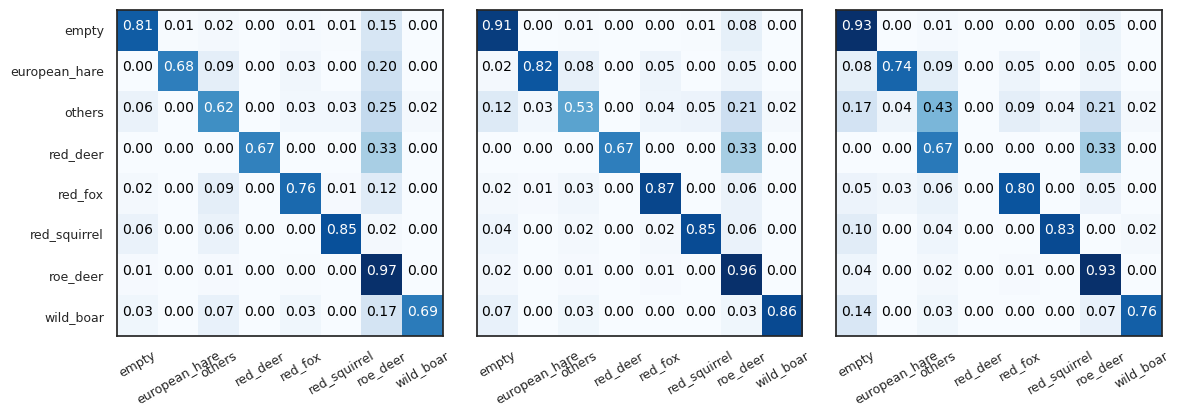

In [14]:
fig, ax = plt.subplots(1,3, figsize=(12, 6), tight_layout=True, sharey=True)

for index_tresh in range(3):
    threshold = df.loc[index_tresh, 'thresholds']
    df_pred = rf.build_df_pred(eval_details_dict[threshold], label_dict, detector_dict, image_data_dir)
    df_pred = rf.labelize_df_pred(df_pred, label_map)
    df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')
    
    rf.inspect_confusion(
        df_pred=df_pred, 
        normalize=True, 
        labels=labels, 
        ax=ax[index_tresh])

plt.show()
plt.close()

In [15]:
#_paper_

#XX% of empty images are correctly detected (TN) 
#only XX% are falsely labeled as empty where in fact they contain animals (FN)
TN = df.loc[0, 'tnr_ppl'] 
FN = df.loc[0, 'fnr_ppl']
print(f'{TN}% of empty images are correctly detected')
print(f'{FN}% are falsely labeled as empty')

0.8069% of empty images are correctly detected
0.0170% are falsely labeled as empty


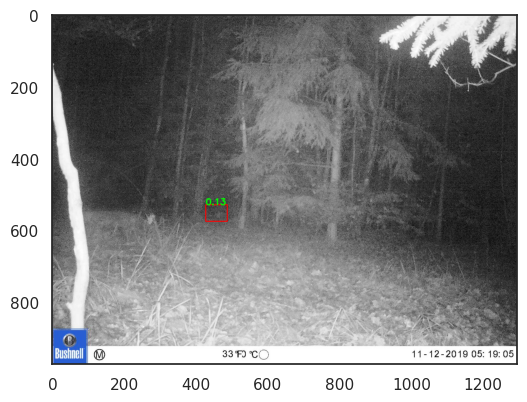

img_name: 46645_11120079.JPG
true_class: red_fox
pred_class: empty
pred_score: 0.128
n_preds: 1
pred_classes: ['empty']
pred_confs: [1.0]
md_confs: [0.13]
score_dict: {'empty': 0.128, 'european_hare': 0.0, 'others': 0.0, 'red_deer': 0.0, 'red_fox': 0.0, 'red_squirrel': 0.0, 'roe_deer': 0.0, 'wild_boar': 0.0}


In [16]:
#_paper_

#Figure: some false non-empties
rf.inspect_misclasses(
    df_pred=df_pred, 
    test_label='empty', 
    label_map=label_map,
    n_displays=1, 
    is_truth=False,
    sorting='descending',
)

# OUT-OF-SAMPLE

## PASSIVE

In [40]:
eval_details_path = 'results/202211251804_details_oosample_perf.pkl'
eval_details_dict = load_pickle(eval_details_path)

df_pred = rf.build_df_pred(eval_details_dict, label_dict, detector_dict, image_data_dir)
df_pred = rf.labelize_df_pred(df_pred, label_map)
df_pred = pd.merge(df_pred, df_meta, on=['img_name', 'true_class'], how='inner')

pref_dict = rf.evaluate_performance(df_pred['true_class'], df_pred['pred_class'], labels, average='macro',)
macro_perf_oos = {metric: pref_dict[metric] for metric in print_metrics}
print(macro_perf_oos)

{'acc': 0.7815126050420168, 'prec': 0.5107573179633147, 'rec': 0.5467491889462164, 'f1': 0.5079510370781017}


               precision    recall  f1-score   support

        empty       0.84      0.62      0.71       320
european_hare       0.66      0.56      0.61        41
       others       0.32      0.39      0.35       104
     red_deer       0.00      0.00      0.00        21
      red_fox       0.35      0.46      0.40        13
 red_squirrel       0.25      0.75      0.38         4
     roe_deer       0.83      0.91      0.87      1040
    wild_boar       0.84      0.67      0.75       123

     accuracy                           0.78      1666
    macro avg       0.51      0.55      0.51      1666
 weighted avg       0.78      0.78      0.78      1666



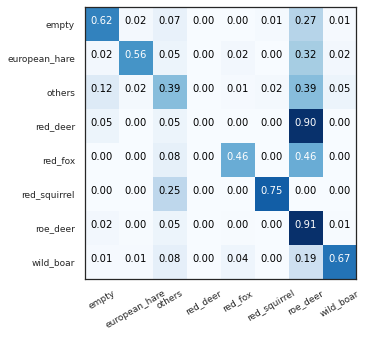

In [41]:
#_paper_

# Table: OOS performance 
report = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report)
# for AL eval
report_lower_perf_limit_dict = classification_report(
    y_true=df_pred['true_class'], 
    y_pred=df_pred['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=True,
)

rf.inspect_confusion(
    df_pred=df_pred, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [19]:
#_paper_
# Table: compare INS va. OOS (macro averages)

df = pd.DataFrame(index=print_metrics)
df['ins']= macro_perf_ins.values()
df['oos']= macro_perf_oos.values()
df

,ins,oos
acc,0.884397,0.781513
prec,0.869295,0.510757
rec,0.769420,0.546749
f1,0.812167,0.507951


## ACTIVE

In [5]:
eval_upper_perf_limit = load_pickle(
    'results/202212011038_results_oosample_active_optimal.json'
)
eval_al_coldstart = load_pickle('results/202212011548_eval_logfile_coldstart.json')
eval_al_warmstart = load_pickle(
    'results/202212011038_results_oosample_active_warmstart.json'
)

In [6]:
df_pred_upper_perf_limit = rf.build_df_pred(eval_upper_perf_limit, label_dict, detector_dict, image_data_dir)
df_pred_upper_perf_limit = rf.labelize_df_pred(df_pred_upper_perf_limit, label_map)
df_pred_upper_perf_limit = pd.merge(df_pred_upper_perf_limit, df_meta, on=['img_name', 'true_class'], how='inner')

In [8]:
df_pred_upper_perf_limit

,img_name,true_class,pred_class,pred_score,n_preds,pred_classes,pred_confs,md_confs,md_bboxs,all_scores,img_path,doy,hour,station,station_set
0,10004_I_00041c.JPG,roe_deer,others,0.914,1,[others],[0.914],[1.0],"[[0.6379, 0.4542, 0.04067, 0.1118]]","[0.0, 0.0, 0.914, 0.0, 0.0, 0.0, 0.085, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,303,6,5933_4_For,s2
1,10007_I_00111c.JPG,roe_deer,roe_deer,1.000,1,[roe_deer],[1.0],[1.0],"[[0.1884, 0.4411, 0.2996, 0.4882]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,332,15,5933_4_For,s2
2,10008_I_00227a.JPG,european_hare,european_hare,0.946,1,[european_hare],[0.946],[1.0],"[[0.5761, 0.4631, 0.08635, 0.1522]]","[0.0, 0.946, 0.008, 0.0, 0.001, 0.0, 0.045, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,364,6,5933_4_For,s2
3,10024_I_00114a.JPG,roe_deer,roe_deer,1.000,1,[roe_deer],[1.0],[1.0],"[[0.2142, 0.4408, 0.2892, 0.5102]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,332,15,5933_4_For,s2
4,10027_I_00259c.JPG,roe_deer,roe_deer,1.000,1,[roe_deer],[1.0],[1.0],"[[0.3493, 0.3025, 0.3492, 0.4304]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,21,16,5933_4_For,s2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,9968_I_00031c.JPG,roe_deer,roe_deer,1.000,1,[roe_deer],[1.0],[1.0],"[[0.4887, 0.3717, 0.148, 0.3678]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,295,18,5933_4_For,s2
1655,9980_I_00025a.JPG,roe_deer,roe_deer,0.554,1,[roe_deer],[0.554],[1.0],"[[0.5667, 0.2799, 0.1154, 0.2629]]","[0.0, 0.0, 0.0, 0.0, 0.446, 0.0, 0.554, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,290,2,5933_4_For,s2
1656,9985_I_00180a.JPG,roe_deer,roe_deer,1.000,1,[roe_deer],[1.0],[1.0],"[[0.03208, 0.4328, 0.9662, 0.5312]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,343,6,5933_4_For,s2
1657,9986_I_00258c.JPG,roe_deer,roe_deer,0.997,2,"[roe_deer, roe_deer]","[0.986, 1.0]","[0.3, 1.0]","[[0.8978, 0.2627, 0.05416, 0.1071], [0.235, 0....","[0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.997, 0.0]",/common/bothmannl/wildlife_images/usecase2/ori...,19,9,5933_4_For,s2


               precision    recall  f1-score   support

        empty       0.95      0.72      0.82       336
european_hare       0.91      0.89      0.90        44
       others       0.54      0.69      0.61       120
     red_deer       0.93      0.70      0.80        20
      red_fox       0.83      0.77      0.80        13
 red_squirrel       1.00      0.50      0.67         4
     roe_deer       0.90      0.96      0.93      1004
    wild_boar       0.96      0.86      0.91       118

     accuracy                           0.88      1659
    macro avg       0.88      0.76      0.80      1659
 weighted avg       0.89      0.88      0.88      1659



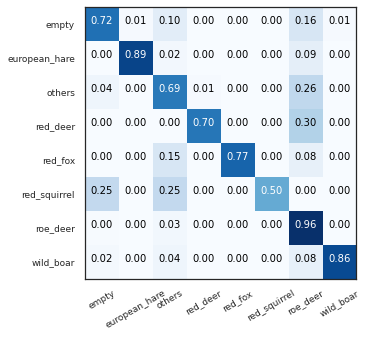

In [7]:
report_upper_perf_limit = classification_report(
    y_true=df_pred_upper_perf_limit['true_class'], 
    y_pred=df_pred_upper_perf_limit['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=False,
)
print(report_upper_perf_limit)

rf.inspect_confusion(
    df_pred=df_pred_upper_perf_limit, 
    normalize=True, 
    labels=labels, 
    ax=None,
)

In [21]:
report_upper_perf_limit_dict = classification_report(
    y_true=df_pred_upper_perf_limit['true_class'], 
    y_pred=df_pred_upper_perf_limit['pred_class'], 
    labels=labels,
    zero_division=0,
    output_dict=True,
)
print(report_upper_perf_limit_dict)

{'empty': {'precision': 0.94921875, 'recall': 0.7232142857142857, 'f1-score': 0.8209459459459459, 'support': 336}, 'european_hare': {'precision': 0.9069767441860465, 'recall': 0.8863636363636364, 'f1-score': 0.896551724137931, 'support': 44}, 'others': {'precision': 0.538961038961039, 'recall': 0.6916666666666667, 'f1-score': 0.6058394160583941, 'support': 120}, 'red_deer': {'precision': 0.9333333333333333, 'recall': 0.7, 'f1-score': 0.8, 'support': 20}, 'red_fox': {'precision': 0.8333333333333334, 'recall': 0.7692307692307693, 'f1-score': 0.8, 'support': 13}, 'red_squirrel': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}, 'roe_deer': {'precision': 0.9028944911297853, 'recall': 0.9631474103585658, 'f1-score': 0.9320481927710843, 'support': 1004}, 'wild_boar': {'precision': 0.9622641509433962, 'recall': 0.864406779661017, 'f1-score': 0.9107142857142857, 'support': 118}, 'accuracy': 0.8800482218203737, 'macro avg': {'precision': 0.8783727302358667, 'recal

In [51]:
acc_coldstart = []
rec_coldstart = []
acc_warmstart = []
rec_warmstart = []

for iteration in eval_al_coldstart.keys():
    df_cs = rf.build_df_pred(eval_al_warmstart[iteration], label_dict, detector_dict, image_data_dir)
    df_cs = rf.labelize_df_pred(df_cs, label_map)
    df_cs = pd.merge(df_cs, df_meta, on=['img_name', 'true_class'], how='inner')
    report_cs = classification_report(
        y_true=df_cs['true_class'], 
        y_pred=df_cs['pred_class'], 
        labels=labels,
        zero_division=0,
        output_dict=True,
    )
    df_ws = rf.build_df_pred(eval_al_warmstart[iteration], label_dict, detector_dict, image_data_dir)
    df_ws = rf.labelize_df_pred(df_ws, label_map)
    df_ws = pd.merge(df_ws, df_meta, on=['img_name', 'true_class'], how='inner')
    report_ws = classification_report(
        y_true=df_ws['true_class'], 
        y_pred=df_ws['pred_class'], 
        labels=labels,
        zero_division=0,
        output_dict=True,
    )
    acc_coldstart.append(report_cs['accuracy'])
    rec_coldstart.append(report_cs['weighted avg']['recall'])
    acc_warmstart.append(report_ws['accuracy'])
    rec_warmstart.append(report_ws['weighted avg']['recall'])

In [52]:
al_perf_acc = {
    'acc_lower_limit': [report_lower_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
    'acc_upper_limit': [report_upper_perf_limit_dict['accuracy'] for _ in range(len(acc_coldstart))],
    'acc_coldstart': acc_coldstart,
    'acc_warmstart': acc_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec = {
    'rec_lower_limit': [report_lower_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
    'rec_upper_limit': [report_upper_perf_limit_dict['weighted avg']['recall'] for _ in range(len(acc_coldstart))],
    'rec_coldstart': rec_coldstart,
    'rec_warmstart': rec_warmstart
}
al_perf_acc_pd = pd.DataFrame(al_perf_acc)
al_perf_rec_pd = pd.DataFrame(al_perf_rec)

<AxesSubplot:>

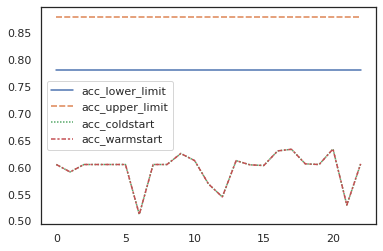

In [54]:
sns.lineplot(data=al_perf_acc)

<AxesSubplot:>

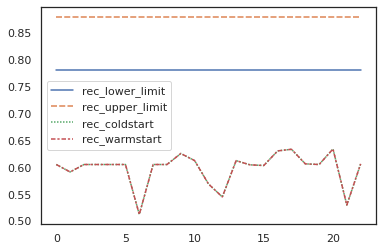

In [55]:
sns.lineplot(data=al_perf_rec)